In [29]:
#!pip install google-cloud-bigquery pandas db-dtypes google-cloud-bigquery-storage
import os
from google.cloud import bigquery
import pandas as pd

import db_dtypes



print("db-dtypes is installed correctly.")


# Set the credentials for Google BigQuery
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "st312-442610-b9934d6c7287.json"
client = bigquery.Client()


db-dtypes is installed correctly.


In [30]:
from classes import *

### Step 1 - get the transaction hashes for everything we want in the period


In [31]:

query = """
SELECT `hash`
  FROM `bigquery-public-data.crypto_polygon.transactions`
  WHERE to_address = "0x78769d50be1763ed1ca0d5e878d93f05aabff29e"
  AND block_timestamp BETWEEN "2024-07-01 00:00:00" AND "2024-07-01 23:59:59"
"""

transaction_hashes = client.query(query).to_dataframe()

transaction_hashes.head()

,hash
0,0x1e6ec8459c39d80db5b9b9afdf80db80911881c224c4...
1,0xafe8f35dc36c33ca8c9781ae8ce6ed334e65f221ee63...
2,0xf30986d4291ffa318eb99aac8cc1f89fc72356fa209e...
3,0x2e240b796ee23615fc324d3be83f985fd0b11b0d2902...
4,0x3e1782069da087ea8eb08e5b944b6f6f333df9f0b1bc...


In [33]:
len(transaction_hashes)

9517

# Step 2 - get all the logs for each transactions


#### Assumption 1 
* only use orders matched and that all orders matached are 0x63bf4d16b7fa898ef4c4b2b6d90fd201e9c56313b65638af6088d149d2ce956c

Cred Evelyne Ong the Second

In [41]:
batch_size = 2500
matched_df = pd.DataFrame()
filled_df = pd.DataFrame()


#for i in range(0, len(), batch_size):
for i in range(0, len(transaction_hashes), batch_size):
    # Get the current batch of 100 transaction hashes
    batch_hashes = transaction_hashes['hash'][i:i + batch_size].tolist()

    # Create the IN clause with the batch of hashes
    hashes_in_clause = "', '".join(batch_hashes)



    
    # Prepare the query with the IN clause
    query = f"""
    SELECT transaction_hash, address, `data`, topics, block_timestamp
    FROM `bigquery-public-data.crypto_polygon.logs`
    WHERE transaction_hash IN ('{hashes_in_clause}')
    AND block_timestamp BETWEEN "2024-07-01 00:00:00" AND "2024-07-01 23:59:59"

    """


    
    # Execute the query
    cur_logs = client.query(query).to_dataframe()


    
    # Filter the logs as needed
    orders_matched = cur_logs[cur_logs['topics'].apply(lambda x: x[0] == "0x63bf4d16b7fa898ef4c4b2b6d90fd201e9c56313b65638af6088d149d2ce956c")]
    orders_filled = cur_logs[cur_logs['topics'].apply(lambda x: x[0] == "0xd0a08e8c493f9c94f29311604c9de1b4e8c8d4c06bd0c789af57f2d65bfec0f6")]


    # Concatenate the results
    matched_df = pd.concat([matched_df, orders_matched], ignore_index=True)
    filled_df = pd.concat([filled_df, orders_filled], ignore_index=True)




In [42]:
matched_df

,transaction_hash,address,data,topics,block_timestamp
0,0x58ff64ed0343af63c320a5541cba474d265059295ed2...,0xc5d563a36ae78145c45a50134d48a1215220f80a,0x00000000000000000000000000000000000000000000...,[0x63bf4d16b7fa898ef4c4b2b6d90fd201e9c56313b65...,2024-07-01 19:15:35+00:00
1,0x0aea9edb48213809f839370512b3a06220148474051e...,0xc5d563a36ae78145c45a50134d48a1215220f80a,0x00000000000000000000000000000000000000000000...,[0x63bf4d16b7fa898ef4c4b2b6d90fd201e9c56313b65...,2024-07-01 21:06:10+00:00
2,0xebf0cea2ae35a1306d78e8cda1a58068bf3930ae5323...,0xc5d563a36ae78145c45a50134d48a1215220f80a,0x00000000000000000000000000000000000000000000...,[0x63bf4d16b7fa898ef4c4b2b6d90fd201e9c56313b65...,2024-07-01 12:42:51+00:00
3,0xe9b86295f627bb2a15675a0bf1ab36aba34294b337a0...,0xc5d563a36ae78145c45a50134d48a1215220f80a,0x00000000000000000000000000000000000000000000...,[0x63bf4d16b7fa898ef4c4b2b6d90fd201e9c56313b65...,2024-07-01 13:46:53+00:00
4,0x81859d770b9b017733955557abe03f6c30cf924ac09a...,0xc5d563a36ae78145c45a50134d48a1215220f80a,0x00000000000000000000000000000000000000000000...,[0x63bf4d16b7fa898ef4c4b2b6d90fd201e9c56313b65...,2024-07-01 11:20:39+00:00
...,...,...,...,...,...
9472,0xa1b4bfc4b451be237606b775c115ef2661c25973fd14...,0xc5d563a36ae78145c45a50134d48a1215220f80a,0x00000000000000000000000000000000000000000000...,[0x63bf4d16b7fa898ef4c4b2b6d90fd201e9c56313b65...,2024-07-01 01:51:49+00:00
9473,0x7d79fdb3199b234b7dab27a7089a249091f5b2abbbbf...,0xc5d563a36ae78145c45a50134d48a1215220f80a,0x00000000000000000000000000000000000000000000...,[0x63bf4d16b7fa898ef4c4b2b6d90fd201e9c56313b65...,2024-07-01 13:52:17+00:00
9474,0xf6a1e496fac98d768c3f47f64fdf4de97e67d491f310...,0xc5d563a36ae78145c45a50134d48a1215220f80a,0x00000000000000000000000000000000000000000000...,[0x63bf4d16b7fa898ef4c4b2b6d90fd201e9c56313b65...,2024-07-01 09:53:31+00:00
9475,0xd01e2a0d991ef1f18a4c4e2fd3473a8f7dd687fadea9...,0xc5d563a36ae78145c45a50134d48a1215220f80a,0x00000000000000000000000000000000000000000000...,[0x63bf4d16b7fa898ef4c4b2b6d90fd201e9c56313b65...,2024-07-01 21:32:06+00:00


# Now we extract the data!



# Step 3-  Now we got the data! We need to process it!

In [ ]:


people = {}
stockExchange = StockPortfolio()


def handle_orders(df):

    maker = df.iloc[0]['maker']
    taker = df.iloc[0]['taker']
    maker_asset_id = df.iloc[0]['maker_asset_id']
    taker_asset_id = df.iloc[0]['taker_asset_id']
    maker_amount = df.iloc[0]['maker_amount']
    taker_amount = df.iloc[0]['taker_amount']

    timeStamp = df.iloc[0]['block_timestamp']
    


    if maker not in people:
        people[maker] = Person(maker, 0)

    if taker not in people:
        people[taker] = Person(taker, 0)






    if maker_asset_id == "000000000000000000000000000000000000000000000000000000000000000":
        ### Maker is buying!
        people[maker].buy(taker_asset_id, taker_amount, maker_amount) 
        people[taker].sell(taker_asset_id, taker_amount, maker_amount)

        stockExchange.add_price(taker_asset_id, timeStamp, makerAmmount/takerAmount)

    if taker_asset_id == "000000000000000000000000000000000000000000000000000000000000000":
        # Taker is selling!
        people[taker].buy(maker_asset_id,maker_amount, taker_amount)
        people[maker].sell(maker_asset_id, maker_amount, taker_amount) 
        stockExchange.add_price(maker_asset_id, timeStamp, taker_amount/maker_amount)

    



for index, row in matched_df.iterrows():

    taker_order_hash = row["topics"][1]

    transaction_hash = row["transaction_hash"]
    
    data = row["data"]
    maker_asset_id = data[2:66]
    taker_asste_id = data[66:130]
    maker_amount = int(data[130:194], 16)
    taker_amount = int(data[194:258], 16)


    ### Now i get into order fillin!

    cur_filled = filled_df[filled_df['transaction_hash'] == transaction_hash]

    cur_filled["takeOrderHash"] = cur_filled["topics"].apply(lambda x: x[1])


    cur_filled = cur_filled[cur_filled["takeOrderHash"] == taker_order_hash]

    if len(cur_filled) == 0:
        pass
    if len(cur_filled) == 1:
        # oh yes!
        cur_filled["maker"] = cur_filled["topics"].apply(lambda x: x[2])
        cur_filled["taker"] = cur_filled["topics"].apply(lambda x: x[3])
        cur_filled["maker_asset_id"] = cur_filled["data"].str[2:66]
        cur_filled["taker_asset_id"] = cur_filled["data"].str[67:130]
        cur_filled["maker_amount"] = cur_filled["data"].str[130:194].apply(lambda x: int(x, 16))
        cur_filled["taker_amount"] = cur_filled["data"].str[194:258].apply(lambda x: int(x, 16))

        subset_df = cur_filled[["maker", "taker", "maker_asset_id", "taker_asset_id", "maker_amount", "taker_amount", "block_timestamp"]]
        
        handle_orders(subset_df)



'0xc322a6757cd2efac7efe88d63649f65f665f074ca260dce8dfd671a79e1b2f40'

In [48]:
people["0x000000000000000000000000c5d563a36ae78145c45a50134d48a1215220f80a"].balance

-557862462510

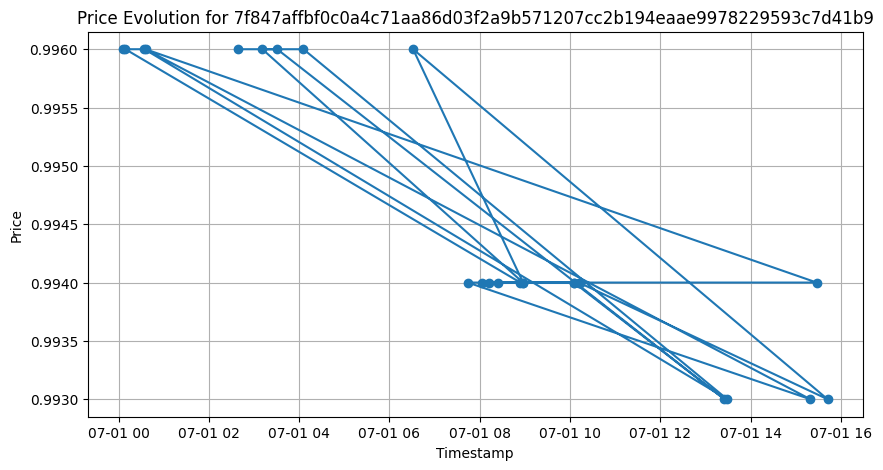

In [47]:
stockExchange.stocks["7f847affbf0c0a4c71aa86d03f2a9b571207cc2b194eaae9978229593c7d41b9"].plot_prices()

In [55]:
len(stockExchange.stocks)

369

# saving!

In [ ]:
import pickle

In [ ]:


with open("./people.pkl", "wb") as f:
    pickle.dump(people, f)



# saving objects (saves the whole dictionary of objects)
with open("./exchnage.pkl", "wb") as f:
    pickle.dump(stockExchange, f)

In [ ]:

with open("./exchnage.pkl", "rb") as f:
    loaded_exchahnge = pickle.load(f)

len(loaded_exchahnge.stocks

369